# Packages and Configurations

In [57]:
import numpy as np

import hoomd
import gsd.hoomd
import fresnel
import freud

import IPython
from matplotlib import pyplot as plt

In [58]:
N_particles = 64
halfside = 0.5
name = "cube"
sphere_radius = 4 * halfside
sphere_origin = (0.0, 0.0, 0.0)
seed = np.random.randint(np.iinfo(np.int16).max)
print(seed)

25986


In [59]:
seedless_file_suffix = f"{name}-{sphere_radius/halfside * 3**-0.5}-\
    ({sphere_origin[0]},{sphere_origin[1]})"
file_suffix = seedless_file_suffix + f"-{seed}"

In [60]:
vertices = [
    (-halfside, -halfside, -halfside),
    (-halfside, halfside, -halfside),
    (halfside, halfside, -halfside),
    (halfside, -halfside, -halfside),
    (halfside, -halfside, halfside),
    (-halfside, -halfside, halfside),
    (-halfside, halfside, halfside),
    (halfside, halfside, halfside)
]

# Plotting and Animation

In [61]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)
def render(snapshot):
    sidelen = snapshot.configuration.box[0]
    poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.ConvexPolyhedron(scene,
                                                 poly_info,
                                                 N=snapshot.particles.N)
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([0.0, 0.0, 0.81]), roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.orientation[:] = snapshot.particles.orientation[:]
    geometry.outline_width = 0.01
    geometry.outline_material = fresnel.material.Material(
        color=fresnel.color.linear([1.0, 0.0, 0.0]), roughness=1.0)
    box = fresnel.geometry.Box(scene,
                               snapshot.configuration.box,
                               box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=np.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=np.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(sidelen * 2, sidelen, sidelen * 2),
        look_at=(0, 0, 0), up=(0, 1, 0), height=sidelen * 1.4 + 1)
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

# Initial System Configuration

In [62]:
spacing = halfside * 4
grid_dim = np.math.ceil((2 * N_particles)**(1/3))
init_box_size = grid_dim * spacing

In [63]:
coordinates = np.mgrid[
    (-init_box_size/2 + spacing/2):(init_box_size/2 - spacing/2):complex(0, grid_dim),
    (-init_box_size/2 + spacing/2):(init_box_size/2 - spacing/2):complex(0, grid_dim),
    (-init_box_size/2 + spacing/2):(init_box_size/2 - spacing/2):complex(0, grid_dim)

]
lattice = np.column_stack((coordinates[0].flat,
                           coordinates[1].flat,
                           coordinates[2].flat))
pierced_lattice = lattice[
    np.linalg.norm(lattice - sphere_origin, axis=1)
    >= sphere_radius + halfside * 3**0.5
]

In [64]:
position = pierced_lattice[:N_particles]
orientation = np.zeros((N_particles, 4))
orientation[:, -1] = 1

In [65]:
snapshot = gsd.hoomd.Snapshot()
snapshot.particles.N = N_particles
snapshot.particles.position = position
snapshot.particles.orientation = orientation
snapshot.particles.typeid = np.zeros(N_particles, dtype=np.int64)
snapshot.particles.types = [name]
snapshot.configuration.box = [init_box_size, init_box_size, init_box_size, 0, 0, 0]
with gsd.hoomd.open(f"data/lattice-{seedless_file_suffix}.gsd", mode="wb") as f:
    f.append(snapshot)

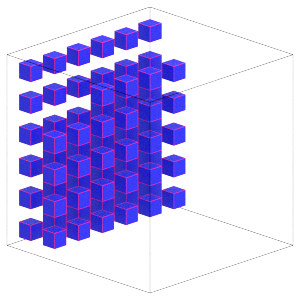

In [66]:
render(snapshot)

In [67]:
sim = hoomd.Simulation(device=hoomd.device.CPU(), seed=seed)
sim.create_state_from_gsd(f"data/lattice-{seedless_file_suffix}.gsd")

## Polyhedron Integrator

In [68]:
mc = hoomd.hpmc.integrate.ConvexPolyhedron(nselect=1)
mc.shape[name] = dict(vertices=vertices)
mc.d[name] = halfside
mc.a[name] = np.pi / 8
sim.operations.integrator = mc

## Spherical Block

In [69]:
mc.external_potential = hoomd.hpmc.external.wall.WallPotential(
    [hoomd.wall.Sphere(origin=sphere_origin, radius=sphere_radius, inside=False)])

# Mixing to a Random Configuration

In [70]:
sim.run(100 * N_particles)

In [71]:
hoomd.write.GSD.write(
    sim.state, f"data/mixed-{file_suffix}.gsd", mode="wb")

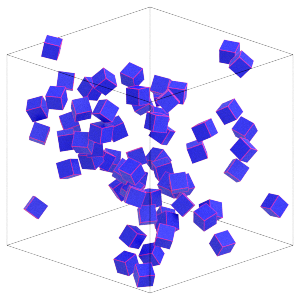

In [72]:
render(sim.state.get_snapshot())

# Compression to Critical Density

In [73]:
V_particle = 8 * halfside**3
initial_volume_fraction = (N_particles * V_particle
                           / (sim.state.box.volume - sphere_radius**3))
print(initial_volume_fraction)

0.037209302325581395


In [74]:
final_box = hoomd.Box.from_box(sim.state.box)
final_volume_fraction = 0.45
final_box.volume = (N_particles * V_particle
                    / final_volume_fraction
                    + sphere_radius**3)
compress = hoomd.hpmc.update.QuickCompress(
    trigger=hoomd.trigger.Periodic(10), target_box=final_box)
sim.operations.updaters.append(compress)

## Tuning the Acceptance Ratio

In [75]:
tune = hoomd.hpmc.tune.MoveSize.scale_solver(
    moves=['a', 'd'], target=0.2, trigger=hoomd.trigger.Periodic(10),
    max_translation_move=halfside/2, max_rotation_move=np.pi/8)
sim.operations.tuners.append(tune)

## Running the Compression

In [76]:
sim.run(10000 * N_particles)

In [77]:
N_particles * V_particle / (sim.state.box.volume - sphere_radius**3)

0.396898770032391

In [ ]:
if not compress.complete:
    raise RuntimeError("Compression failed to complete")

In [80]:
hoomd.write.GSD.write(
    sim.state, f"data/compressed-{file_suffix}.gsd", mode="wb")

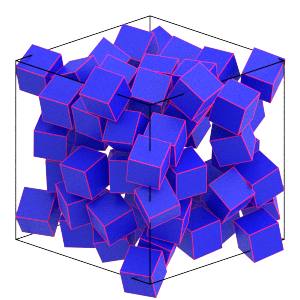

In [79]:
render(sim.state.get_snapshot())

# Equilibriating the System
## Tuning the Acceptance Ratio

In [81]:
sim.operations.tuners.pop()
tune = hoomd.hpmc.tune.MoveSize.scale_solver(
    moves=['a', 'd'],
    target=0.2,
    trigger=hoomd.trigger.And([
        hoomd.trigger.Periodic(100),
        hoomd.trigger.Before(sim.timestep + 100 * N_particles)
    ]))
sim.operations.tuners.append(tune)

In [82]:
sim.run(1000 * N_particles)
sim.run(500)
translation_acceptance = mc.translate_moves[0] / sum(mc.translate_moves)
rotation_acceptance = mc.rotate_moves[0] / sum(mc.rotate_moves)
translation_acceptance, rotation_acceptance

(0.21200574676744333, 0.20405227940716653)

## Adding State Recorder

In [83]:
gsd_writer = hoomd.write.GSD(
    filename=f"data/trajectory-{file_suffix}.gsd", mode="wb",
    trigger=hoomd.trigger.Periodic(N_particles))
sim.operations.writers.append(gsd_writer)

## Running the Simulation

In [84]:
sim.run(10000 * N_particles)

In [85]:
traj = gsd.hoomd.open(f"data/trajectory-{file_suffix}.gsd")

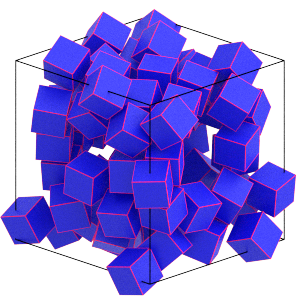

In [86]:
render(sim.state.get_snapshot())

In [87]:
solid = freud.order.SolidLiquid(l=6, q_threshold=0.7, solid_threshold=6)
is_solid = []
for frame in traj:
    solid.compute(system=(frame.configuration.box, frame.particles.position),
                  neighbors=dict(mode='nearest', num_neighbors=8))
    is_solid.append(solid.num_connections > solid.solid_threshold)

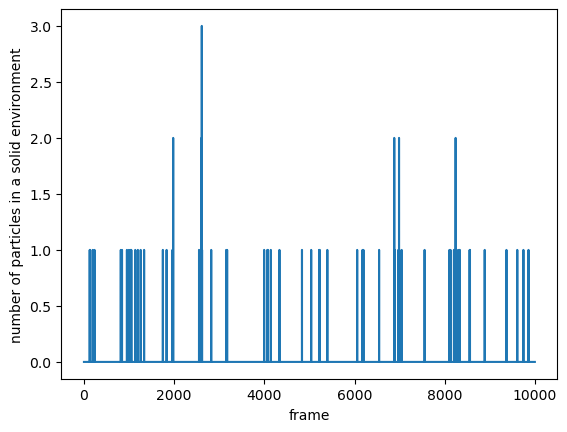

In [88]:
fig, ax = plt.subplots()
num_solid = np.array([np.sum(a) for a in is_solid])
ax.plot(num_solid)
ax.set_xlabel('frame')
ax.set_ylabel('number of particles in a solid environment')
plt.show()